In [49]:
import pandas as pd
import numpy as np
# import tensorflow as tf
from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# from sklearn.feature_selection import SelectKBest
# from sklearn.pipeline import make_pipeline
from nltk.corpus import stopwords

## Importing Data

- Combine title & review into one column
- Binary Encode target labels

In [29]:
df = pd.read_csv('../data/Airline_review.csv')[['Review_Title','Review','Recommended']]
reviews = df['Review_Title'] + ' ' + df['Review']
labels = df['Recommended'].map({'yes':1,'no':0})

## Data Understanding

- Standard cleaning and tokenization for understanding
- Number of Reviews
- Number and distribution of target
- Number of words per review
- Frequency distribution of words
- Distribution of review length

**Next Steps**: 
- Maybe show difference between yes and no reviews
- also show after stopwords have been removed

In [32]:
# Standard cleaning and tokenization for understanding
from nltk.corpus import wordnet
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

def get_wordnet_pos(treebank_tag):
    """Convert treebank POS tags to wordnet POS tags."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text(document, stop_words = None):
    """
    Clean and preprocess the text document.
    
    Parameters:
        document (str): The text document to clean.
        stop_words (list): A list of stop words to exclude.
        
    Returns:
        str: The cleaned and lemmatized text.
    """
    # Initialize a tokenizer with a regex for words and contractions
    tokenizer = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    
    # Tokenize the document
    tokens = tokenizer.tokenize(document)
    
    # Convert tokens to lowercase if not a stop word
    if stop_words == None:
        tokens = [word.lower() for word in tokens]
    else:
        tokens = [word.lower() for word in tokens if word.lower() not in stop_words]
    
    # Tag tokens with part-of-speech tags
    pos_tags = pos_tag(tokens)
    
    # Convert treebank POS tags to wordnet POS tags
    wordnet_tags = [(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    
    # Initialize the lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Lemmatize words based on their POS tags
    lemmatized_tokens = [lemmatizer.lemmatize(word, tag) for word, tag in wordnet_tags]
    
    return lemmatized_tokens
reviews_tokened = [clean_text(review) for review in reviews]

In [33]:
# Number of Reviews
len(df)

23171

In [36]:
# Number and distribution of target
display(df['Recommended'].value_counts())
print('')
display(df['Recommended'].value_counts(normalize=True))

Recommended
no     15364
yes     7807
Name: count, dtype: int64

Recommended
no     0.66307
yes    0.33693
Name: proportion, dtype: float64

In [45]:
# Number of words per review
review_lengths = [len(review) for review in reviews_tokened]
np.median(num_words)

105.0

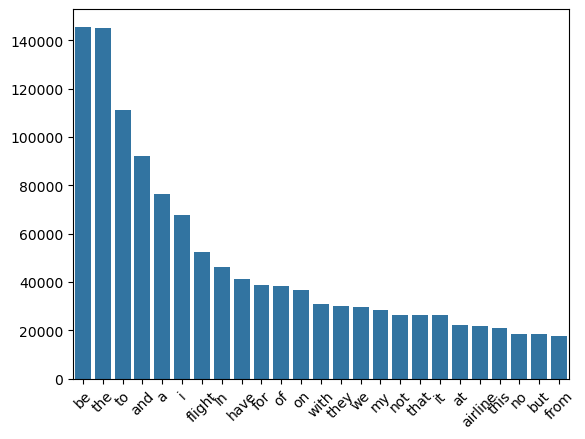

In [43]:
# Frequency distribution of words
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import seaborn as sns

fdist = FreqDist(word for review in reviews_tokened for word in review)
top_words = fdist.most_common(25)
words = []
counts = []
for word, count in top_words:
    words.append(word)
    counts.append(count)

fig, ax = plt.subplots()
sns.barplot(x=words, y=counts, ax= ax)
plt.xticks(rotation=45)
plt.show()

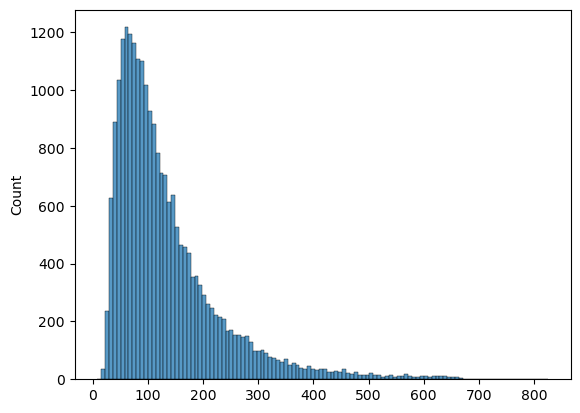

In [47]:
# Distribution of review length
sns.histplot(review_lengths)
plt.show()

## Data Preparation

- Split raw data into train-val-test sets
- Manually Normalize
  - Remove punctuation
  - remove stop words
  - lowercase
  - part of speech tags
  - lemmanize
- Normalize by creating tensorflow datasets
  - CountVectorization
  - TfidfVecorization 

In [65]:
# Make 80-10-10 train-validation-test split

# First split with stratification
train_reviews, temp_reviews, train_labels, temp_labels = train_test_split(reviews, labels, test_size=0.2, stratify=labels, random_state=42)

# Second split for val and test sets with stratification
val_reviews, test_reviews, val_labels, test_labels = train_test_split(temp_reviews, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

def label_distribution(name,labels):
    total = len(labels)
    yes_counts = (labels==1).sum()
    yes_rate = yes_counts/total
    no_counts = (labels==0).sum()
    no_rate = no_counts/total
    print(f'{name} Labels')
    print('  Yes Reviews:')
    print(f'     Count: {yes_counts}')
    print(f'     Percent: {round(100*yes_rate,2)}%')
    print('  No Reviews:')
    print(f'     Count: {no_counts}')
    print(f'     Percent: {round(100*no_rate,2)}%')
    print('')

label_distribution('Training',train_labels)
label_distribution('Validation',val_labels)
label_distribution('Testing',test_labels)

Training Labels
  Yes Reviews:
     Count: 6245
     Percent: 33.69%
  No Reviews:
     Count: 12291
     Percent: 66.31%

Validation Labels
  Yes Reviews:
     Count: 781
     Percent: 33.71%
  No Reviews:
     Count: 1536
     Percent: 66.29%

Testing Labels
  Yes Reviews:
     Count: 781
     Percent: 33.69%
  No Reviews:
     Count: 1537
     Percent: 66.31%



In [66]:
# I don't need to do this as I will include it in my pipeline
# Manual Normalization including stopword removal
# STOPWORDS = stopwords.words('english')

# X_train = [clean_text(review, stop_words = STOPWORDS) for review in train_reviews]
# X_val = [clean_text(review, stop_words = STOPWORDS) for review in val_reviews]
# X_test = [clean_text(review, stop_words = STOPWORDS) for review in test_reviews]

In [67]:
# Creating tensorflow datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfTransformer
import tensorflow as tf

def vectorize_text(train_reviews, val_reviews, test_reviews, stop_words, use_tf_idf=False):
    """
    Vectorizes text data. Optionally applies TF-IDF transformation.
    """
    vectorizer = CountVectorizer(decode_error='replace', strip_accents='unicode', stop_words=stop_words,
                                 ngram_range=(1, 2), max_df=0.95, min_df=2)
    if use_tf_idf:
        pipeline = make_pipeline(vectorizer, TfidfTransformer())
        X_train = pipeline.fit_transform(train_reviews)
        X_val = pipeline.transform(val_reviews)
        X_test = pipeline.transform(test_reviews)
    else:
        X_train = vectorizer.fit_transform(train_reviews)
        X_val = vectorizer.transform(val_reviews)
        X_test = vectorizer.transform(test_reviews)
    return X_train, X_val, X_test

def select_features(X_train, train_labels, X_val, X_test, k_best=20000):
    """
    Selects the k best features from the vectorized text data.
    """
    selector = SelectKBest(k=min(k_best, X_train.shape[1]))
    selector.fit(X_train, train_labels)
    X_train_selected = selector.transform(X_train)
    X_val_selected = selector.transform(X_val)
    X_test_selected = selector.transform(X_test)
    return X_train_selected, X_val_selected, X_test_selected

def create_tf_datasets(X_train_selected, train_labels, X_val_selected, val_labels, X_test_selected, test_labels):
    """
    Converts selected features and labels into TensorFlow datasets.
    """
    train_ds = tf.data.Dataset.from_tensor_slices((X_train_selected.toarray(), train_labels.astype('float32')))
    val_ds = tf.data.Dataset.from_tensor_slices((X_val_selected.toarray(), val_labels.astype('float32')))
    test_ds = tf.data.Dataset.from_tensor_slices((X_test_selected.toarray(), test_labels.astype('float32')))
    
    train_ds = train_ds.shuffle(1000, reshuffle_each_iteration=True).batch(64).cache().prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.batch(64).cache().prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.batch(64).cache().prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds, test_ds

def prepare_datasets(train_reviews, train_labels, val_reviews, val_labels, test_reviews, test_labels, stop_words, use_tf_idf=False, k_best=20000):
    """
    Prepares training and validation datasets by vectorizing text data, selecting features,
    and converting to TensorFlow datasets.
    """
    X_train, X_val, X_test = vectorize_text(train_reviews, val_reviews, test_reviews, stop_words, use_tf_idf)
    X_train_selected, X_val_selected, X_test_selected = select_features(X_train, train_labels, X_val, X_test, k_best)
    train_ds, val_ds, test_ds = create_tf_datasets(X_train_selected, train_labels, X_val_selected, val_labels, X_test_selected, test_labels)
    return train_ds, val_ds, test_ds

# Counts
train_ds_counts, val_ds_counts, test_ds_counts = prepare_datasets(train_reviews, train_labels, val_reviews, val_labels, test_reviews, test_labels, STOPWORDS)

# Tf-idf
train_ds_tfidf, val_ds_tfidf, test_ds_tfidf = prepare_datasets(train_reviews, train_labels, val_reviews, val_labels, test_reviews, test_labels, STOPWORDS, use_tf_idf=True)

2024-03-27 12:18:26.821225: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Modeling

- Dummy
- Baseline: LogisticRegression
- 
- 
- 

In [77]:
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.corpus import wordnet
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

class TextCleanerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, stop_words=None):
        self.stop_words = stop_words
        
    def fit(self, X, y=None):
        return self  # Nothing to do here
    
    def transform(self, X, y=None):
        cleaned_reviews = []
        for review in X:
            cleaned_reviews.append(self.clean_text(review, self.stop_words))
        return cleaned_reviews
    
    def clean_text(self, review, stop_words):
        tokenizer = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
        tokens = tokenizer.tokenize(review)
        if stop_words is None:
            tokens = [word.lower() for word in tokens]
        else:
            tokens = [word.lower() for word in tokens if word.lower() not in stop_words]
        
        pos_tags = pos_tag(tokens)
        wordnet_tags = [(word, self.get_wordnet_pos(tag)) for word, tag in pos_tags]
        lemmatizer = WordNetLemmatizer()
        lemmatized_tokens = [lemmatizer.lemmatize(word, tag) for word, tag in wordnet_tags]
        return ' '.join(lemmatized_tokens)
    
    def get_wordnet_pos(self, treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN
def model_cv_scores(pipeline, model_name, X= None, y= None, scoring=None, cv=None):
    """
    Performs cross-validation on the given pipeline and data, displaying the results.
    
    Parameters:
    - pipeline: The scikit-learn pipeline to evaluate.
    - model_name: A name for the model, used in the output DataFrame.
    - X: The feature matrix. Default is None. Should be provided explicitly.
    - y: The target vector. Default is None. Should be provided explicitly.
    - scoring: Scoring parameter for cross-validation. Default is None. Should be provided explicitly.
    - cv: Cross-validation splitting strategy. Default is None. Should be provided explicitly.
    
    Returns:
    - A dictionary containing the cross-validation scores.
    """
    scores = cross_validate(pipeline, X, y, scoring=scoring, cv=cv, n_jobs=-1, return_train_score=False)
    
    # Calculating mean values and rounding them for readability
    time = round((scores['fit_time'] + scores['score_time']).mean())
    accuracy = round(scores['test_accuracy'].mean(), 4)
    roc_auc = round(scores['test_roc_auc'].mean(), 4)
    
    # Creating and displaying a DataFrame with the results
    results_df = pd.DataFrame([[accuracy, roc_auc, time]], 
                              index=[model_name], 
                              columns=['Accuracy', 'ROC AUC', 'Time (s)'])
    display(results_df)

def RandCV_scores(model_name,random_search):
    index = random_search.best_index_
    results = random_search.cv_results_

    # Calculating mean values and rounding them for readability
    time = round(results['mean_fit_time'][index] + results['mean_score_time'][index])
    accuracy = round(results['mean_test_accuracy'][index], 4)
    roc_auc = round(results['mean_test_roc_auc'][index], 4)
    
    # Creating and displaying a DataFrame with the results
    results_df = pd.DataFrame([[accuracy, roc_auc, time]], 
                              index=[model_name+'_RandCV'], 
                              columns=['Accuracy', 'ROC AUC', 'Time (s)'])
    display(results_df)
    return random_search.best_params_

In [100]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline

# Instantiating processing transformers
text_cleaner = TextCleanerTransformer(stop_words=STOPWORDS)
vectorizer = CountVectorizer(decode_error='replace', strip_accents='unicode', stop_words=None, ngram_range=(1, 2), max_df=0.95, min_df=2)
tf_idf = TfidfTransformer()
k_best = SelectKBest(k=10000)

# Setting CV parameters
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
SCORING = {'accuracy':'accuracy',
           'roc_auc':'roc_auc'}

# Concatenating the valildation set as I don't need it here. 90-10 split
X_train = pd.concat([train_reviews, val_reviews])
y_train = pd.concat([train_labels, val_labels])

# Clean data before entering the pipeline for efficiency
X_train_clean = text_cleaner.transform(X_train)

In [105]:
# Dummy Model
from sklearn.dummy import DummyClassifier

clf = DummyClassifier(strategy='uniform', random_state=42)

pipe = Pipeline([
    ("count", vectorizer),
    ('feature_selection', k_best),
    ("dummy", clf)])

model_cv_scores(pipe, 'Dummy', X= X_train_clean, y= y_train, scoring=SCORING, cv=skf)

,Accuracy,ROC AUC,Time (s)
Dummy,0.5022,0.5,5


#### CountVectorizer

In [107]:
# Baseline
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000)

pipe = Pipeline([
    ("count", vectorizer),
    ('feature_selection', k_best),
    ("log_reg", clf)])

model_cv_scores(pipe, 'log_reg', X= X_train_clean, y= y_train, scoring=SCORING, cv=skf)

,Accuracy,ROC AUC,Time (s)
log_reg,0.8977,0.9523,6


In [122]:
# Logistic Regression RandCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

clf = LogisticRegression()

pipe = Pipeline([
    ("count", vectorizer),
    ('feature_selection', k_best),
    ("log_reg", clf)])

params = {
    'log_reg__C': loguniform(0.001, 100),
    'log_reg__solver': ['liblinear', 'lbfgs', 'sag', 'newton-cg'],
    'log_reg__max_iter': [100, 200, 300, 400, 500]
}

rs = RandomizedSearchCV(estimator= pipe, 
                        param_distributions= params,
                        n_iter=100, 
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        scoring=SCORING,
                        refit= 'roc_auc',
                        random_state=42)
rand_search = rs.fit(X_train_clean, y_train)
RandCV_scores('log_reg',rand_search)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/ronlodetti/anaconda3/envs/capstone-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ronlodetti/anaconda3/envs/capstone-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ronlodetti/anaconda3/envs/capstone-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ronlodetti/anaconda3/envs/capstone-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ronlodetti/anaconda3/envs/capstone-env/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

,Accuracy,ROC AUC,Time (s)
log_reg_RandCV,0.9029,0.9581,8


{'log_reg__C': 0.061991000078022655,
 'log_reg__max_iter': 100,
 'log_reg__solver': 'newton-cg'}

In [123]:
# MultinomialNB
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(alpha=1.0, fit_prior=True)

pipe = Pipeline([
    ("count", vectorizer),
    ('feature_selection', k_best),
    ("mnb", clf)])

model_cv_scores(pipe, 'mnb', X= X_train_clean, y= y_train, scoring=SCORING, cv=skf)

,Accuracy,ROC AUC,Time (s)
mnb,0.8748,0.9341,6


In [125]:
# MultinomialNB RandCV
clf = MultinomialNB()

pipe = Pipeline([
    ("count", vectorizer),
    ('feature_selection', k_best),
    ("mnb", clf)])

params = {
    'mnb__alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0],
    'mnb__fit_prior': [True, False],
    'mnb__class_prior': [None,[0.66,0.34]]
}

rs = RandomizedSearchCV(estimator= pipe, 
                        param_distributions= params,
                        n_iter=100, 
                        cv=5,
                        verbose=1,
                        n_jobs=-1,
                        scoring=SCORING,
                        refit= 'roc_auc',
                        random_state=42)
rand_search = rs.fit(X_train_clean, y_train)
RandCV_scores('mnb',rand_search)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Users/ronlodetti/anaconda3/envs/capstone-env/lib/python3.11/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 24 is smaller than n_iter=100. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


,Accuracy,ROC AUC,Time (s)
mnb_RandCV,0.8745,0.934,8


{'mnb__fit_prior': True, 'mnb__class_prior': [0.66, 0.34], 'mnb__alpha': 0.1}

In [126]:
# SVC
from sklearn.svm import SVC

clf = SVC(C=1.0, kernel='rbf', gamma='scale')

pipe = Pipeline([
    ("count", vectorizer),
    ('feature_selection', k_best),
    ("svc", clf)])

model_cv_scores(pipe, 'svc', X= X_train_clean, y= y_train, scoring=SCORING, cv=skf)
# Too Slow even for one round, not doing RandomizedCV

,Accuracy,ROC AUC,Time (s)
svc,0.9045,0.959,144


In [128]:
# GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,
                                    max_depth=3, min_samples_split=2,
                                    max_features=None)

pipe = Pipeline([
    ("count", vectorizer),
    ('feature_selection', k_best),
    ("gbc", clf)])

model_cv_scores(pipe, 'gbc', X= X_train_clean, y= y_train, scoring=SCORING, cv=skf)

,Accuracy,ROC AUC,Time (s)
gbc,0.8699,0.94,16


In [130]:
# GradientBoostingClassifier RandCV
clf = GradientBoostingClassifier()

pipe = Pipeline([
    ("count", vectorizer),
    ('feature_selection', k_best),
    ("gbc", clf)])

params = {
    'gbc__n_estimators': [100, 200, 300],  # Number of boosting stages
    'gbc__learning_rate': [0.01, 0.05, 0.1, 0.2],  # Learning rate
    'gbc__max_depth': [3, 4, 5, 6],  # Maximum depth of the individual estimators
    'gbc__min_samples_split': [2, 4, 6],  # Minimum number of samples required to split an internal node
    'gbc__max_features': [None, 'sqrt', 'log2'],  # Number of features to consider when looking for the best split
    'gbc__subsample': [0.8, 0.9, 1.0],  # The fraction of samples to be used for fitting the individual base learners
}

rs = RandomizedSearchCV(estimator= pipe, 
                        param_distributions= params,
                        n_iter=100, 
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        scoring=SCORING,
                        refit= 'roc_auc',
                        random_state=42)
rand_search = rs.fit(X_train_clean, y_train)
RandCV_scores('gbc',rand_search)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


KeyboardInterrupt: 

In [131]:
# RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=None,
                                min_samples_split=2, min_samples_leaf=1,
                                max_features='sqrt')
pipe = Pipeline([
    ("count", vectorizer),
    ('feature_selection', k_best),
    ("rfc", clf)])

model_cv_scores(pipe, 'rfc', X= X_train_clean, y= y_train, scoring=SCORING, cv=skf)

,Accuracy,ROC AUC,Time (s)
rfc,0.8862,0.9488,30


In [ ]:
# RandomForestClassifier RandCV
clf = RandomForestClassifier()

pipe = Pipeline([
    ("count", vectorizer),
    ('feature_selection', k_best),
    ("rfc", clf)])

params = {
    'rfc__n_estimators': [100, 200, 300, 400, 500],  # Number of trees
    'rfc__max_depth': [None, 10, 20, 30, 40, 50],  # Maximum depth of the trees
    'rfc__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'rfc__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'rfc__max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider for the best split
    'rfc__bootstrap': [True, False],  # Method of selecting samples for training each tree
}

rs = RandomizedSearchCV(estimator= pipe, 
                        param_distributions= params,
                        n_iter=100, 
                        cv=5,
                        verbose=1,
                        n_jobs=-1,
                        scoring=SCORING,
                        refit= 'roc_auc',
                        random_state=42)
rand_search = rs.fit(X_train_clean, y_train)
RandCV_scores('rfc',rand_search)

#### TfidfVectorizer

In [132]:
# Baseline
clf = LogisticRegression(max_iter=1000)

pipe = Pipeline([
    ("count", vectorizer),
    ('tf_idf',tf_idf),
    ('feature_selection', k_best),
    ("log_reg", clf)])

model_cv_scores(pipe, 'log_reg', X= X_train_clean, y= y_train, scoring=SCORING, cv=skf)

,Accuracy,ROC AUC,Time (s)
log_reg,0.9001,0.959,6


In [133]:
# MultinomialNB
clf = MultinomialNB(alpha=1.0, fit_prior=True)

pipe = Pipeline([
    ("count", vectorizer),
    ('tf_idf',tf_idf),
    ('feature_selection', k_best),
    ("mnb", clf)])

model_cv_scores(pipe, 'mnb', X= X_train_clean, y= y_train, scoring=SCORING, cv=skf)

,Accuracy,ROC AUC,Time (s)
mnb,0.8833,0.9458,6


In [134]:
# SVC
clf = SVC(C=1.0, kernel='rbf', gamma='scale')

pipe = Pipeline([
    ("count", vectorizer),
    ('tf_idf',tf_idf),
    ('feature_selection', k_best),
    ("svc", clf)])

model_cv_scores(pipe, 'svc', X= X_train_clean, y= y_train, scoring=SCORING, cv=skf)

,Accuracy,ROC AUC,Time (s)
svc,0.9073,0.9589,206


In [135]:
# GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,
                                    max_depth=3, min_samples_split=2,
                                    max_features=None)
pipe = Pipeline([
    ("count", vectorizer),
    ('tf_idf',tf_idf),
    ('feature_selection', k_best),
    ("gbc", clf)])

model_cv_scores(pipe, 'gbc', X= X_train_clean, y= y_train, scoring=SCORING, cv=skf)

,Accuracy,ROC AUC,Time (s)
gbc,0.8721,0.9402,47


In [136]:
# RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=None,
                                min_samples_split=2, min_samples_leaf=1,
                                max_features='sqrt')
pipe = Pipeline([
    ("count", vectorizer),
    ('tf_idf',tf_idf),
    ('feature_selection', k_best),
    ("rfc", clf)])

model_cv_scores(pipe, 'rfc', X= X_train_clean, y= y_train, scoring=SCORING, cv=skf)

,Accuracy,ROC AUC,Time (s)
rfc,0.8896,0.9504,29
